In [2]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import TensorBoard
import time

C:\Users\MONSTER\anaconda3\envs\image\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\MONSTER\anaconda3\envs\image\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\MONSTER\anaconda3\envs\image\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
DIRECTORY = r"D:/Datasets/BGYF_Dataset"
CATEGORIES = os.listdir(DIRECTORY)
CATEGORY_SIZE = len(CATEGORIES)
class_types  = CATEGORIES
IMG_SIZE = 64
patch_size=4 

In [3]:
# grab the list of images in our dataset directory, then initialize the list of data (i.e., images) and class images
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    filelist = os.listdir(path)
    for fichier in filelist[:]: # filelist[:] makes a copy of filelist.
        if not(fichier.endswith(".jpg")):
            filelist.remove(fichier)
    
    for img in filelist:
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        
        image = img_to_array(image)
        
        data.append(image)
        labels.append(category)
        

In [4]:
category

'H'

In [5]:
# perform one-hot encoding on the labels
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# define example
values = array(labels)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
labels = tf.keras.utils.to_categorical(integer_encoded, num_classes=2, dtype='uint8')


data = np.array(data, dtype='uint8')
labels = np.array(labels)

In [6]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=3)

In [7]:
training_data = tf.data.Dataset.from_tensor_slices((trainX, trainY))
validation_data = tf.data.Dataset.from_tensor_slices((testX, testY))


In [8]:
autotune = tf.data.AUTOTUNE
train_data_batches = training_data.shuffle(buffer_size=160, seed=3).batch(16).prefetch(buffer_size=autotune)
valid_data_batches = validation_data.shuffle(buffer_size=40, seed=3).batch(4).prefetch(buffer_size=autotune)

train_ds = (training_data.shuffle(160, seed=3).batch(16).prefetch(autotune))
valid_ds = (validation_data.shuffle(40, seed=3).batch(4).prefetch(autotune))

In [9]:
print ('train im and label types: ', type(trainX), type(trainY))

train im and label types:  <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [10]:
print ('check types; ', type(training_data), type(validation_data))

check types;  <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'> <class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>


In [11]:
class generate_patch(layers.Layer):
    def __init__(self, patch_size):
        super(generate_patch, self).__init__()
        self.patch_size = patch_size
    
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(images=images, 
                                           sizes=[1, self.patch_size, self.patch_size, 1], 
                                           strides=[1, self.patch_size, self.patch_size, 1], rates=[1, 1, 1, 1], padding="VALID")
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims]) #here shape is (batch_size, num_patches, patch_h*patch_w*c) 
        return patches

check shapes:  (1, 64, 64, 3)
patch per image and patches shape:  256 
 (1, 256, 48)


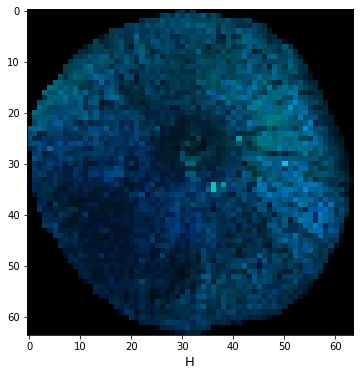

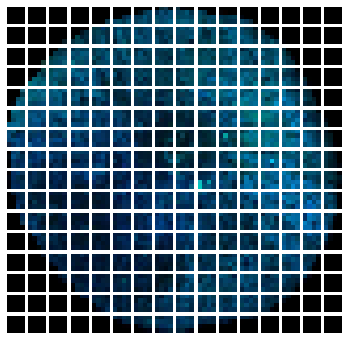

In [12]:
from itertools import islice, count

train_iter_7im, train_iter_7label = next(islice(training_data, 7, None)) # access the 7th element from the iterator



train_iter_7im = tf.expand_dims(train_iter_7im, 0)
train_iter_7label = train_iter_7label.numpy()

print('check shapes: ', train_iter_7im.shape) 

######################
# num patches (W * H) /P^2 where W, H are from original image, P is patch dim. 
# Original image (H * W * C), patch N * P*P *C, N num patches
######################
generate_patch_layer = generate_patch(patch_size=patch_size)
patches = generate_patch_layer(train_iter_7im)

print ('patch per image and patches shape: ', patches.shape[1], '\n', patches.shape)



def render_image_and_patches(image, patches):
    plt.figure(figsize=(6, 6))
    plt.imshow(tf.cast(image[0], tf.uint8))
    plt.xlabel(class_types [np.argmax(train_iter_7label)], fontsize=13)
    n = int(np.sqrt(patches.shape[1]))
    plt.figure(figsize=(6, 6))
    #plt.suptitle(f"Image Patches", size=13)
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i+1)
        patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
        ax.imshow(patch_img.numpy().astype("uint8"))
        ax.axis('off')    

        


render_image_and_patches(train_iter_7im, patches)

In [13]:
### Positonal Encoding Layer

class PatchEncode_Embed(layers.Layer):
    '''
    2 steps happen here
    1. flatten the patches 
    2. Map to dim D; patch embeddings  
    '''
    def __init__(self, num_patches, projection_dim):
        super(PatchEncode_Embed, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)# activation = linear
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim)
    
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [14]:
patch_encoder = PatchEncode_Embed(256, 256)(patches)
print (tf.shape(patch_encoder))

tf.Tensor([  1 256 256], shape=(3,), dtype=int32)


In [15]:
class generate_patch_conv(layers.Layer):
    '''
    this is an example to generate conv patches comparable with the image patches
    generated using tf extract image patches. This wasn't the original implementation, specially 
    the number of filters in the conv layer has nothing to do with patch size. It must be same as
    hidden dim (query/key dim) in relation to multi-head attention layer.       
    '''
    def __init__(self, patch_size):
        super(generate_patch_conv, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = layers.Conv2D(self.patch_size*self.patch_size*3, self.patch_size, self.patch_size, padding='valid')(images)

        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches  

class generate_patch_conv_orgPaper(layers.Layer):
    '''
    original implementation, 
    hidden size = query/key dim in multi head attention layer later. 
    '''
    def __init__(self, patch_size, hidden_size):
        super(generate_patch_conv_orgPaper, self).__init__()
        self.patch_size = patch_size
        self.hidden_size = hidden_size

    def call(self, images):
        patches = layers.Conv2D(self.hidden_size, self.patch_size, self.patch_size, padding='valid', name='Embedding')(images) 
        # kernels and strides = patch size
        # the weights of the convolutional layer will be learned. 
        rows_axis, cols_axis = (1, 2) # channels last images
        #if channels_last:
            #rows_axis, cols_axis = (2, 3) # for channels last
            # x = tf.transpose(patches, perm=[0, 2, 3, 1]) # do this for channels_first
        seq_len = (images.shape[rows_axis] // patch_size) * (images.shape[cols_axis] // patch_size)
        x = tf.reshape(patches, [-1, seq_len, self.hidden_size])
        return x

def generate_patch_conv_orgPaper_f(patch_size, hidden_size, inputs):
    patches = layers.Conv2D(filters=hidden_size, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
    row_axis, col_axis = (1, 2) # channels last images
    seq_len = (inputs.shape[row_axis] // patch_size) * (inputs.shape[col_axis] // patch_size)
    x = tf.reshape(patches, [-1, seq_len, hidden_size])
    return x




train_iter_7im = tf.cast(train_iter_7im, dtype=tf.float16)
generate_patch_conv_layer = generate_patch_conv(patch_size=patch_size)
patches_conv = generate_patch_conv_layer(train_iter_7im)


print ('patch per image and patches shape: ', patches_conv.shape[1], '\n', patches_conv.shape)    

generate_patch_conv_orgPaper_layer = generate_patch_conv_orgPaper(patch_size=patch_size, hidden_size=64)
patches_conv_org = generate_patch_conv_orgPaper_layer(train_iter_7im)

hidden_size=64
patches_conv_org_f = generate_patch_conv_orgPaper_f(patch_size, hidden_size, train_iter_7im)

print ('patch per image and patches shape: ', patches_conv_org.shape[1], '\n', patches_conv_org.shape)
print ('patch per image and patches shape: ', patches_conv_org_f.shape[1], '\n', patches_conv_org_f.shape)

patch per image and patches shape:  256 
 (1, 256, 48)
patch per image and patches shape:  256 
 (1, 256, 64)
patch per image and patches shape:  256 
 (1, 256, 64)


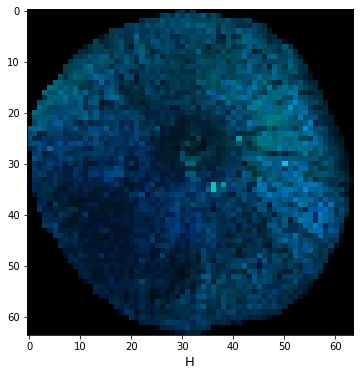

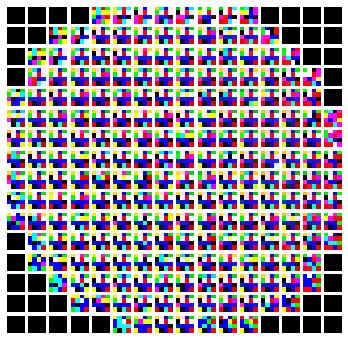

In [16]:
def render_image_and_patches(image, patches):
    plt.figure(figsize=(6, 6))
    plt.imshow(tf.cast(image[0], tf.uint8))
    plt.xlabel(class_types [np.argmax(train_iter_7label)], fontsize=13)
    n = int(np.sqrt(patches.shape[1]))
    plt.figure(figsize=(6, 6))
    #plt.suptitle(f"Image Patches", size=13)
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i+1)
        patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
        ax.imshow(patch_img.numpy().astype("uint8"))
        ax.axis('off')

render_image_and_patches(train_iter_7im, patches_conv)

In [17]:
# x_conv = layers.Conv2D(64, patch_size, patch_size, padding='valid')(train_iter_7im)

# print(x_conv.shape)

# #x_conv = tf.transpose(x_conv, perm=[0, 2, 3, 1])

# #print(x_conv.shape)

# seq_len = (train_iter_7im.shape[1] // patch_size) * (train_iter_7im.shape[2] // patch_size)

# x = tf.reshape(x_conv, [-1, seq_len, 64])

# print(x.shape)

In [18]:
### Positonal Encoding Layer

class AddPositionEmbs(layers.Layer):
    """Adds (optionally learned) positional embeddings to the inputs."""

    def __init__(self, posemb_init=None, **kwargs):
        super().__init__(**kwargs)
        self.posemb_init = posemb_init
        #posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02), name='posembed_input') # used in original code

    def build(self, inputs_shape):
        pos_emb_shape = (1, inputs_shape[1], inputs_shape[2])
        self.pos_embedding = self.add_weight('pos_embedding', pos_emb_shape, initializer=self.posemb_init)

    def call(self, inputs, inputs_positions=None):
        # inputs.shape is (batch_size, seq_len, emb_dim).
        pos_embedding = tf.cast(self.pos_embedding, inputs.dtype)

        return inputs + pos_embedding


pos_embed_layer = AddPositionEmbs(posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02))
embedded_inp = pos_embed_layer(patches_conv_org)

print ('embedded input shape: ', embedded_inp.shape)

embedded input shape:  (1, 256, 64)


In [19]:
# class mlp_block(layers.Layer):
#   def __init__(self, mlp_dim):
#     super(mlp_block, self).__init__()
#     self.mlp_dim = mlp_dim
#   def call(self, inputs):
#     x = layers.Dense(units=self.mlp_dim, activation=tf.nn.gelu)(inputs)
#     x = layers.Dropout(rate=0.1)(x) # dropout rate is from original paper,
#     x = layers.Dense(units=inputs.shape[-1], activation=tf.nn.gelu)(x)
#     x = layers.Dropout(rate=0.1)(x)
#     return x


def mlp_block_f(mlp_dim, inputs):
    x = layers.Dense(units=mlp_dim, activation=tf.nn.gelu)(inputs)
    x = layers.Dropout(rate=0.04)(x) # dropout rate is from original paper,
    x = layers.Dense(units=inputs.shape[-1], activation=tf.nn.gelu)(x)
    x = layers.Dropout(rate=0.04)(x)
    return x

# class Encoder1Dblock(layers.Layer):
#   def __init__(self, num_heads, mlp_dim):
#     super(Encoder1Dblock, self).__init__()
#     self.num_heads = num_heads # number of heads in multi-head block
#     self.mlp_dim = mlp_dim
#   def call(self, inputs):
#     x = layers.LayerNormalization(dtype=self.dtype)(inputs)
#     x = layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=inputs.shape[-1], dropout=0.1)(x, x) # self attention multi-head, dropout_rate is from original implementation
#     x = layers.Add()([x, inputs]) # 1st residual part 
    
    # #### mlp block 
    # y = layers.LayerNormalization(dtype=self.dtype)(x)
    # y = mlp_block(mlp_dim=self.mlp_dim)(y)
    # y_1 = layers.Add()([y, x]) #2nd residual part 
    # return y_1


def Encoder1Dblock_f(num_heads, mlp_dim, inputs):
    x = layers.LayerNormalization(dtype=inputs.dtype)(inputs)
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1], dropout=0.04)(x, x) # self attention multi-head, dropout_rate is from original implementation
    x = layers.Add()([x, inputs]) # 1st residual part 
  
    y = layers.LayerNormalization(dtype=x.dtype)(x)
    y = mlp_block_f(mlp_dim, y)
    y_1 = layers.Add()([y, x]) #2nd residual part 
    return y_1


#########################################
# test with the embeddings as input
#########################################
# Encoder1Dblock_layer = Encoder1Dblock(num_heads=4, mlp_dim=32)
# Encoder1Dblock_layer_out = Encoder1Dblock_layer(embedded_inp)
Encoder1Dblock_layer_out_f = Encoder1Dblock_f(4, 32, embedded_inp)

# print ('output shape of Encoder block when inputs are the embeddings: ', Encoder1Dblock_layer_out.shape)
print ('output shape of Encoder block when inputs are the embeddings: ', Encoder1Dblock_layer_out_f.shape)

output shape of Encoder block when inputs are the embeddings:  (1, 256, 64)


In [20]:
# explicitly check the implementation with 2 transformer encoder blocks

# def build_ViT_Param():
#   inputs = layers.Input(shape=train_im.shape[1:])
#   # rescaling (normalizing pixel val between 0 and 1)
#   rescale = rescale_layer(inputs)
#   # augmentation 
#   augmented = data_augmentation(rescale)
#   # generate patches with conv layer
#   patches = generate_patch_conv_orgPaper(patch_size=patch_size, hidden_size=hidden_size)(augmented)
#   embeddings = AddPositionEmbs(posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02))(patches)
#   embeddings = layers.Dropout(rate=0.4)(embeddings)

#   ######################################
#   # ready for the transformer blocks
#   # block 1
#   ######################################

#   ###############################
#   # attention block 1
#   ##############################

#   x_1 = layers.LayerNormalization(dtype=embeddings.dtype)(embeddings)
#   x_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1], dropout=0.1)(x_1, x_1) # self attention multi-head, dropout_rate is from original implementation
#   x_1 = layers.Add()([x_1, embeddings]) # 1st residual part 
    
#   #### mlp block 1
#   y_1 = layers.LayerNormalization(dtype=x_1.dtype)(x_1)
#   x_2 = layers.Dense(units=mlp_dim, activation='relu')(y_1)
#   x_2 = layers.Dropout(rate=0.1)(x_2) # dropout rate is from original paper,
#   x_2 = layers.Dense(units=y_1.shape[-1], activation=tf.nn.gelu)(x_2)
#   x_2 = layers.Dropout(rate=0.1)(x_2)
#   y_2 = layers.Add()([x_1, x_2]) #2nd residual part

#   # ######################################
#   # # ready for the transformer blocks
#   # # block 2
#   # ######################################

#   # ###############################
#   # # attention block 2
#   # ##############################

#   x_3 = layers.LayerNormalization(dtype=y_2.dtype)(y_2)
#   x_3 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1], dropout=0.1)(x_3, x_3) # self attention multi-head, dropout_rate is from original implementation
#   x_3 = layers.Add()([x_3, y_2]) # 1st residual part 
    
#   # #### mlp block 2
#   y_3 = layers.LayerNormalization(dtype=x_2.dtype)(x_3)
#   x_4 = layers.Dense(units=mlp_dim, activation=tf.nn.gelu)(y_3)
#   x_4 = layers.Dropout(rate=0.1)(x_4) # dropout rate is from original paper,
#   x_4 = layers.Dense(units=y_3.shape[-1], activation=tf.nn.gelu)(x_4)
#   x_4 = layers.Dropout(rate=0.1)(x_4)
#   y_4 = layers.Add()([x_3, x_4]) #2nd residual part

#   encoder_out = layers.LayerNormalization()(y_4)  

#   # #####################################
#   # #  final part (mlp to classification)
#   # #####################################
#   # #encoder_out_rank = int(tf.experimental.numpy.ndim(encoder_out))
#   im_representation = tf.reduce_mean(encoder_out, axis=1)  # (1,) or (1,2)

#   logits = layers.Dense(units=len(class_types), name='head', kernel_initializer=tf.keras.initializers.zeros)(im_representation) # !!! important !!! activation is linear 

#   final_model = tf.keras.Model(inputs = inputs, outputs = logits)

#   return final_model


# vit_model_params = build_ViT_Param()
# vit_model_params.summary()

In [21]:
### augment train but not test 

rescale_layer = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2), 
    layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
    layers.experimental.preprocessing.RandomTranslation(0.3, 0.3, fill_mode='reflect', interpolation='bilinear',)
])


train_ds = (training_data.shuffle(160).batch(16).map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=autotune).prefetch(autotune))
valid_ds = (validation_data.shuffle(40).batch(4).prefetch(autotune))

In [22]:
# class Encoder(layers.Layer):
#   def __init__(self, num_layers, mlp_dim, num_heads):
#     super(Encoder, self).__init__()
#     self.num_layers = num_layers # number of times encoder repeats
#     self.mlp_dim = mlp_dim
#     self.num_heads = num_heads

#   def call(self, inputs):
#     x = AddPositionEmbs(posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02), name='posembed_input')(inputs)
#     x = layers.Dropout(rate=0.2)(x)
#     for _ in range(self.num_layers):
#       x = Encoder1Dblock(mlp_dim=self.mlp_dim, num_heads=self.num_heads)(x)

#     encoded = layers.LayerNormalization(name='encoder_norm')(x)
#     return encoded


def Encoder_f(num_layers, mlp_dim, num_heads, inputs):
    x = AddPositionEmbs(posemb_init=tf.keras.initializers.RandomNormal(stddev=0.02), name='posembed_input')(inputs)
    x = layers.Dropout(rate=0.04)(x)
    for _ in range(num_layers):
        x = Encoder1Dblock_f(num_heads, mlp_dim, x)

    encoded = layers.LayerNormalization(name='encoder_norm')(x)
    return encoded




######################################
# hyperparameter section 
###################################### 
transformer_layers = 6
hidden_size = 64
num_heads = 4
mlp_dim = 128

######################################




def build_ViT():
    inputs = layers.Input(shape=trainX.shape[1:])
    # rescaling (normalizing pixel val between 0 and 1)
    rescale = rescale_layer(inputs)
    # augmentation 
    # augmented = data_augmentation(rescale)
    # generate patches with conv layer
    patches = generate_patch_conv_orgPaper_f(patch_size, hidden_size, rescale)

    ######################################
    # ready for the transformer blocks
    ######################################
    encoder_out = Encoder_f(transformer_layers, mlp_dim, num_heads, patches)  

    #####################################
    #  final part (mlp to classification)
    #####################################
    #encoder_out_rank = int(tf.experimental.numpy.ndim(encoder_out))
    im_representation = tf.reduce_mean(encoder_out, axis=1)  # (1,) or (1,2)

    logits = layers.Dense(units=len(class_types), name='head', kernel_initializer=tf.keras.initializers.zeros)(im_representation) # !!! important !!! activation is linear 

    final_model = tf.keras.Model(inputs = inputs, outputs = logits)
    return final_model



ViT_model = build_ViT()
ViT_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 64, 64, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 16, 16, 64)   3136        ['sequential[0][0]']             
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 256, 64)      0           ['conv2d_2[0][0]']               
                                                                                              

                                                                  'add_6[0][0]']                  
                                                                                                  
 layer_normalization_8 (LayerNo  (None, 256, 64)     128         ['add_7[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_4 (MultiH  (None, 256, 64)     66368       ['layer_normalization_8[0][0]',  
 eadAttention)                                                    'layer_normalization_8[0][0]']  
                                                                                                  
 add_8 (Add)                    (None, 256, 64)      0           ['multi_head_attention_4[0][0]', 
                                                                  'add_7[0][0]']                  
          

In [23]:
tf.keras.utils.plot_model(ViT_model, rankdir='TB')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [24]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.uint8, name=None))>

In [25]:
len(valid_ds)

10

In [26]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.uint8, name=None))>

In [27]:
# Tensorboard
NAME = "{}-{}-{}-{}".format('Transformer', int(time.time()), IMG_SIZE, patch_size)
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))


### model 

ViT_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4), 
                  loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                  metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy")]) 
#tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")],) 
# from logits = True, because Dense layer has linear activation


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=5, min_lr=1e-8, verbose=1)


ViT_Train = ViT_model.fit(train_ds, 
                        epochs = 20, 
                        validation_data=valid_ds, callbacks=[reduce_lr,tensorboard])



Layer AddPositionEmbs has arguments ['self', 'posemb_init']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/20
10/10 [==============================] - 11s 594ms/step - loss: 0.6920 - accuracy: 0.5000 - val_loss: 0.6864 - val_accuracy: 0.5000 - lr: 2.0000e-04
Epoch 2/20
10/10 [==============================] - 2s 194ms/step - loss: 0.6800 - accuracy: 0.5000 - val_loss: 0.6784 - val_accuracy: 0.5000 - lr: 2.0000e-04
Epoch 3/20
10/10 [==============================] - 2s 186ms/step - loss: 0.6610 - accuracy: 0.5000 - val_loss: 0.6465 - val_accuracy: 0.5000 - lr: 2.0000e-04
Epoch 4/20
10/10 [==============================] - 2s 18

NameError: name 'model' is not defined

In [49]:
i=0
for layer in ViT_model.layers:
    i=i+1
    print('{}. Layer weights = {}'.format(i,layer.get_weights()))
    print(layer)
    


1. Layer weights = []
2. Layer weights = []
3. Layer weights = [array([[[[-0.00147295, -0.06591869, -0.00908917, ...,  0.05574336,
           0.05553135,  0.02976707],
         [ 0.0697733 ,  0.03476677,  0.01814675, ...,  0.06602795,
           0.0024947 ,  0.03841292],
         [-0.04232629, -0.02013898,  0.02506356, ..., -0.04432221,
          -0.01255911, -0.07542969]],

        [[ 0.01977638,  0.07185419, -0.00858588, ..., -0.06927334,
           0.06023233, -0.06995124],
         [-0.03048536,  0.03046127,  0.05817334, ..., -0.03783218,
          -0.00577489,  0.05091679],
         [ 0.03716577, -0.0047896 , -0.0492991 , ...,  0.01801866,
          -0.02179441,  0.01848182]],

        [[ 0.0493987 ,  0.03000372, -0.02246385, ..., -0.07269052,
           0.04228075, -0.06102493],
         [ 0.02425917,  0.05575846,  0.0462711 , ...,  0.0356545 ,
          -0.00650209,  0.01702537],
         [-0.00963042,  0.05534276,  0.03348207, ..., -0.00609756,
          -0.04760639, -0.0479409

In [34]:
weights

[array([[[[-0.00147295, -0.06591869, -0.00908917, ...,  0.05574336,
            0.05553135,  0.02976707],
          [ 0.0697733 ,  0.03476677,  0.01814675, ...,  0.06602795,
            0.0024947 ,  0.03841292],
          [-0.04232629, -0.02013898,  0.02506356, ..., -0.04432221,
           -0.01255911, -0.07542969]],
 
         [[ 0.01977638,  0.07185419, -0.00858588, ..., -0.06927334,
            0.06023233, -0.06995124],
          [-0.03048536,  0.03046127,  0.05817334, ..., -0.03783218,
           -0.00577489,  0.05091679],
          [ 0.03716577, -0.0047896 , -0.0492991 , ...,  0.01801866,
           -0.02179441,  0.01848182]],
 
         [[ 0.0493987 ,  0.03000372, -0.02246385, ..., -0.07269052,
            0.04228075, -0.06102493],
          [ 0.02425917,  0.05575846,  0.0462711 , ...,  0.0356545 ,
           -0.00650209,  0.01702537],
          [-0.00963042,  0.05534276,  0.03348207, ..., -0.00609756,
           -0.04760639, -0.04794093]],
 
         [[ 0.04754423, -0.06429511, 

In [ ]:
### Plot train and validation curves
loss = ViT_Train.history['loss']
v_loss = ViT_Train.history['val_loss']

acc = ViT_Train.history['accuracy'] 
v_acc = ViT_Train.history['val_accuracy']


epochs = range(len(loss))

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.yscale('log')
plt.plot(epochs, loss, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Loss')
plt.plot(epochs, v_loss, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Loss')
# plt.ylim(0.3, 100)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Acc')
plt.plot(epochs, v_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Acc') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
# plt.savefig('/content/gdrive/My Drive/Colab Notebooks/resnet/train_acc.png', dpi=250)
plt.show()

In [29]:
#ViT_model.save(NAME)

In [3]:
tf.keras.models.load_model('Transformer-1652840721-256-16')

In [ ]:
model.pred()